Import the necessary packages:

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

Read the dataset:

In [2]:
data_frame = pd.read_csv("../main_datasets/sarcasm_data.csv")
data_frame.head()

,Unnamed: 0.1,Unnamed: 0,label,comment,votes,sentiment
0,0,0,0,NC and NH.,-1,0
1,1,1,0,You do know west teams play against west teams...,-1,1
2,2,2,0,"They were underdogs earlier today, but since G...",3,0
3,3,3,0,"This meme isn't funny none of the ""new york ni...",-1,0
4,4,4,0,I could use one of those tools.,-1,1


In [3]:
data_frame = data_frame[["label", "comment", "votes", "sentiment"]]
data_frame.head()

,label,comment,votes,sentiment
0,0,NC and NH.,-1,0
1,0,You do know west teams play against west teams...,-1,1
2,0,"They were underdogs earlier today, but since G...",3,0
3,0,"This meme isn't funny none of the ""new york ni...",-1,0
4,0,I could use one of those tools.,-1,1


Performing data preprocessing:

In [4]:
def preprocess(text):
    return simple_preprocess(text, deacc=True, min_len=2, max_len=15)

data_frame['preprocessed_text'] = data_frame['comment'].apply(preprocess)
data_frame.head()

,label,comment,votes,sentiment,preprocessed_text
0,0,NC and NH.,-1,0,"[nc, and, nh]"
1,0,You do know west teams play against west teams...,-1,1,"[you, do, know, west, teams, play, against, we..."
2,0,"They were underdogs earlier today, but since G...",3,0,"[they, were, underdogs, earlier, today, but, s..."
3,0,"This meme isn't funny none of the ""new york ni...",-1,0,"[this, meme, isn, funny, none, of, the, new, y..."
4,0,I could use one of those tools.,-1,1,"[could, use, one, of, those, tools]"


Train the Word2Vec model:


In [6]:
embedding_size = 300
word2vec_model = Word2Vec(data_frame['preprocessed_text'], vector_size=embedding_size, window=5, min_count=2, workers=4)
word2vec_model

Create word embeddings using the preprocessed_text feature:

In [7]:
def text_to_embedding(text):
    words = [word for word in text if word in word2vec_model.wv]
    if words:
        return np.mean(word2vec_model.wv[words], axis=0)
    else:
        return np.zeros(embedding_size)

data_frame['embedding'] = data_frame['preprocessed_text'].apply(text_to_embedding)

In [8]:
data_frame.head()

,label,comment,votes,sentiment,preprocessed_text,embedding
0,0,NC and NH.,-1,0,"[nc, and, nh]","[0.21609701, 0.1277005, -0.004275933, -0.23914..."
1,0,You do know west teams play against west teams...,-1,1,"[you, do, know, west, teams, play, against, we...","[0.901033, -0.25148854, 0.03710579, -0.4550235..."
2,0,"They were underdogs earlier today, but since G...",3,0,"[they, were, underdogs, earlier, today, but, s...","[0.5119159, -0.10543205, -0.13608679, 0.099972..."
3,0,"This meme isn't funny none of the ""new york ni...",-1,0,"[this, meme, isn, funny, none, of, the, new, y...","[0.63304996, -0.47775602, -0.019840885, 0.2177..."
4,0,I could use one of those tools.,-1,1,"[could, use, one, of, those, tools]","[0.7111089, -0.40615416, -0.3645107, 0.1240408..."


Create the training and test sets:

In [9]:
embedding_df = pd.DataFrame(data_frame['embedding'].tolist())
expanded_df = pd.concat([data_frame.drop('embedding', axis=1), embedding_df], axis=1)
X = expanded_df.drop('label', axis=1)
y = expanded_df['label']
print(X)
print(y)

                                                   comment  votes  sentiment  \
0                                               NC and NH.     -1          0   
1        You do know west teams play against west teams...     -1          1   
2        They were underdogs earlier today, but since G...      3          0   
3        This meme isn't funny none of the "new york ni...     -1          0   
4                          I could use one of those tools.     -1          1   
...                                                    ...    ...        ...   
1010768  I'm sure that Iran and N. Korea have the techn...      2          0   
1010769                 whatever you do, don't vote green!      1          1   
1010770  Perhaps this is an atheist conspiracy to make ...      1          1   
1010771  The Slavs got their own country - it is called...      1          1   
1010772  values, as in capitalism .. there is good mone...      2          1   

                                       

In [10]:
X = X.drop(columns=["comment", "preprocessed_text"])
X.columns = X.columns.astype(str)
X

,votes,sentiment,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,-1,0,0.216097,0.127700,-0.004276,-0.239149,0.170189,-0.093651,0.177436,0.338791,...,0.142619,0.378785,0.288810,0.231269,0.055302,0.256880,-0.121469,-0.372571,0.146683,-0.311408
1,-1,1,0.901033,-0.251489,0.037106,-0.455024,-0.088450,-0.142761,0.118243,-0.360591,...,-0.294843,0.265665,0.656409,-0.073038,0.135123,-0.383956,0.005241,-0.103584,0.548455,-0.593707
2,3,0,0.511916,-0.105432,-0.136087,0.099973,-0.136520,-0.279869,0.011838,0.412074,...,-0.178842,0.080132,-0.005808,0.110903,-0.370570,-0.056568,-0.407942,-0.270374,0.066079,-0.234304
3,-1,0,0.633050,-0.477756,-0.019841,0.217716,0.515063,-0.327816,0.159793,0.235248,...,-0.339879,0.087431,-0.142550,0.437939,0.044838,-0.041357,0.222470,-0.037596,0.115753,0.064982
4,-1,1,0.711109,-0.406154,-0.364511,0.124041,0.205182,-0.105650,-0.056621,-0.502914,...,-0.345199,0.205526,0.174559,0.130741,-0.435397,0.377231,-0.183876,-0.313148,-0.389411,0.282108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010768,2,0,0.270842,0.130239,0.357152,0.136946,0.065563,-0.139574,0.142453,0.368594,...,-0.035610,0.424718,0.139356,0.118062,-0.098329,-0.106346,0.130115,-0.136063,0.257278,-0.087298
1010769,1,1,0.467090,0.485869,-0.128336,0.164412,0.213655,0.194029,0.010861,-0.512079,...,-0.070678,0.485259,0.125919,-0.099551,0.568679,-0.153646,0.065143,-0.561573,0.019783,-0.282519
1010770,1,1,0.348691,-0.094415,0.273786,-0.303323,0.388416,-0.125813,0.012202,0.508173,...,-0.348823,0.252684,-0.218157,-0.266105,0.268003,-0.101022,0.086047,-0.140891,0.297323,0.137915
1010771,1,1,0.059416,-0.511897,0.132152,-0.091193,0.234953,-0.605470,0.294261,0.394298,...,-0.189738,0.296792,-0.146746,0.187199,-0.205454,-0.363163,-0.127001,-0.228174,-0.099205,-0.092458


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [12]:
model = RandomForestClassifier(n_estimators=10)
model

RandomForestClassifier(n_estimators=10)

In [13]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [14]:
y_pred = model.predict(X_test)

In [15]:
y_pred_proba = model.predict_proba(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65    202020
           1       0.65      0.53      0.58    202290

    accuracy                           0.62    404310
   macro avg       0.62      0.62      0.62    404310
weighted avg       0.62      0.62      0.62    404310



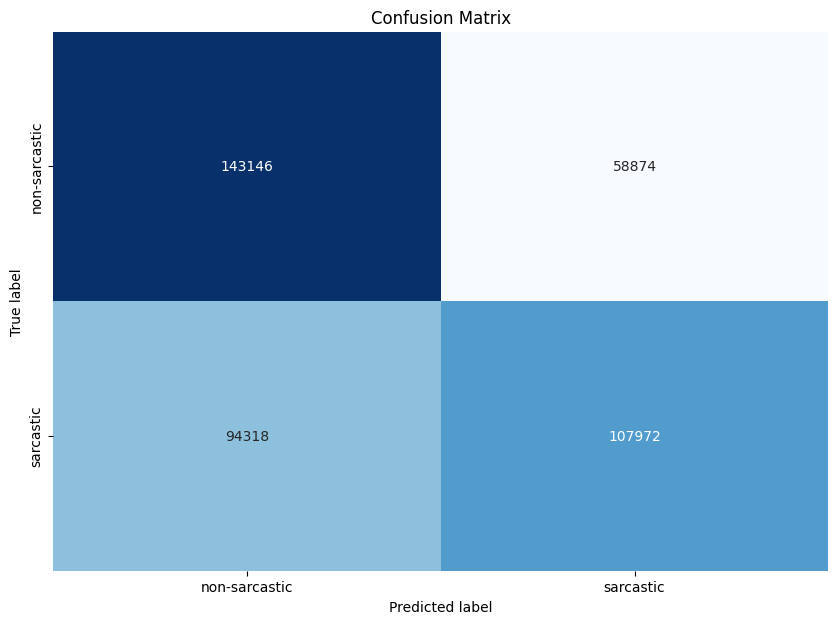

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_normalized, annot=cm, cmap='Blues', fmt='d', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    # Set the axis labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Set the title
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()
plot_confusion_matrix(y_test, y_pred, ["non-sarcastic", "sarcastic"])

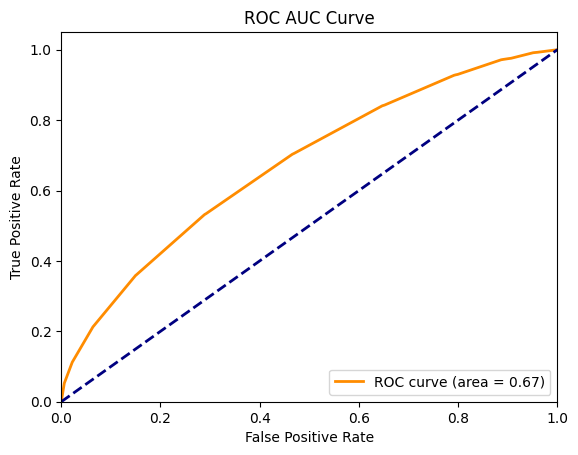

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_auc_curve(y_true, y_pred_proba, title='ROC AUC Curve'):
    # Compute the ROC curve points and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Create the ROC curve plot
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

plot_roc_auc_curve(y_test, y_pred_proba[:,1])


In [21]:
import numpy as np
from sklearn.metrics import roc_curve

def find_best_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Calculate the Youden's J statistic for each threshold
    j_scores = tpr - fpr
    
    # Find the index of the best threshold
    best_threshold_index = np.argmax(j_scores)
    
    # Return the best threshold
    return thresholds[best_threshold_index]

threshold = find_best_threshold(y_test, y_pred_proba[:,1])
threshold

0.5983333333333334

In [24]:
def make_predictions(y_proba) -> int:
    predictions = list()
    for value in y_proba[:,1]:
        if value >= 0.5:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

              precision    recall  f1-score   support

           0       0.64      0.54      0.58    202020
           1       0.60      0.70      0.65    202290

    accuracy                           0.62    404310
   macro avg       0.62      0.62      0.62    404310
weighted avg       0.62      0.62      0.62    404310



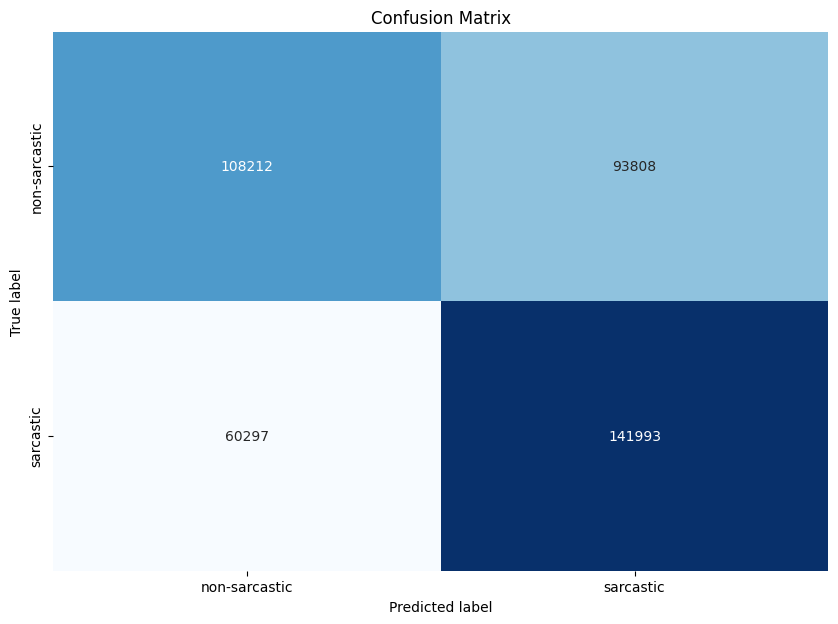

In [25]:
print(classification_report(y_test, make_predictions(y_pred_proba)))
plot_confusion_matrix(y_test, make_predictions(y_pred_proba), ["non-sarcastic", "sarcastic"])

In [26]:
from joblib import dump

dump(model, "RF_embeddings.joblib")

['RF_embeddings.joblib']